# Lineup a 1-D peak : scan detector *v* motor

From *APS Python Training for Bluesky Data Acquisition*.

**Objective**

Line up a motor `m1` to a simulated diffraction peak `noisy`.  Also
monitor a simulated `temperature` signal in a separate stream.

## About the `noisy` peak

In this lesson, alignment to a narrow diffraction peak is using
capabilities provided by the [ophyd](https://blueskyproject.io/ophyd/)
package.  The simulation consists of a simulated motor and simulated
noisy detector.

The noisy detector is configured to describe a narrow diffraction
peak with Gaussian profile based on the value of the motor position.
The peak is centered randomly somewhere between motor 
values -1 and +1.  The width is less than 0.05 in the same units.  The
peak intensity is expected to be approximately 100,000 (counts/sec 
are typical units).

The `noisy` peak simulation (computed using EPICS PV `gp:userCalc1`)
has these parameters:

parameter | description
:--- | :---
peak shape | Lorentzian as function of `m1.position`
center | randomly-placed between -1 .. +1
width | randomly-selected, at most 0.15 (motor units)
scale (height) | randomly-selected, between 10,000 .. 100,000 (counts)
counting noise| randomly-selected, between .01 .. .09 of scale (counts)

The calculation updates `noisy` when a new `m1.position` (`gp:m1.RBV`) value is reported to `gp:userCalc1`.

Since this detector is actually an EPICS calculation using the *swait* record, the concept of counting time was not built into the simulation.

Since we know the peak is somewhere between -1 .. +1, we can limit the scan range.  To ensure the scan crosses the peak, we increase the scan range a bit, to -2 .. 2.

Normally, we'd simulate a more narrow diffraction peak but the resolution of these motors is the limiting factor.

## Start the `instrument` package

Our instrument package is in the `bluesky` subdirectory here so we add that to the search path before importing it.

In [1]:
import pathlib, sys
sys.path.append(str(pathlib.Path.home() / "bluesky"))
from instrument.collection import *

/home/prjemian/bluesky/instrument/_iconfig.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/docs/source/howto/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Thu-17:00:57 - ############################################################ startup
I Thu-17:00:57 - logging started
I Thu-17:00:57 - logging level = 10
I Thu-17:00:57 - /home/prjemian/bluesky/instrument/session_logs.py
I Thu-17:00:57 - /home/prjemian/bluesky/instrument/collection.py
I Thu-17:00:57 - CONDA_PREFIX = /home/prjemian/.conda/envs/bluesky_2023_2


Exception reporting mode: Minimal


I Thu-17:00:57 - xmode exception level: 'Minimal'
I Thu-17:00:57 - /home/prjemian/bluesky/instrument/mpl/notebook.py
I Thu-17:00:57 - #### Bluesky Framework ####
I Thu-17:00:57 - /home/prjemian/bluesky/instrument/framework/check_python.py
I Thu-17:00:57 - /home/prjemian/bluesky/instrument/framework/check_bluesky.py
I Thu-17:00:57 - /home/prjemian/bluesky/instrument/framework/initialize.py
I Thu-17:00:57 - RunEngine metadata saved in directory: /home/prjemian/Bluesky_RunEngine_md
I Thu-17:00:57 - using databroker catalog 'training'
I Thu-17:00:57 - using ophyd control layer: pyepics
I Thu-17:00:57 - /home/prjemian/bluesky/instrument/framework/metadata.py
I Thu-17:00:57 - /home/prjemian/bluesky/instrument/epics_signal_config.py
I Thu-17:00:57 - Using RunEngine metadata for scan_id
I Thu-17:00:58 - #### Devices ####
I Thu-17:00:58 - /home/prjemian/bluesky/instrument/devices/area_detector.py
I Thu-17:00:58 - /home/prjemian/bluesky/instrument/devices/calculation_records.py
I Thu-17:01:00 - 

Let's also monitor the simulated temperature during these scans.

In [2]:
sd.monitors.append(temperature)

## 2-pass scan

Find the peak of noisy v. m1 in the range of +/- 2.  This is a 2 scan procedure.  First scan passes through the full range.  Second scan is centered on the peak and width of the first scan.

We know the peak of the simulated noisy detector is positioned somewhere between -1 to +1.  Overscan that range to find both sides of the peak.

The plan used here comes from our instrument package, `instrument/plans/peak_finder_example.py`.  It's a custom plan that, among other activities, calls the standard bluesky plan for a scan relative to the current position.  The `bp.rel_scan()` is called twice in this custom plan.



Transient Scan ID: 937     Time: 2023-04-13 17:01:15
Persistent Unique Scan ID: 'd3d48c63-299b-4105-b71c-d7f76d384610'
New stream: 'label_start_motor'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 17:01:18.2 |    -2.0000 |  157.59212 |
|         2 | 17:01:18.7 |    -1.8182 |  198.25932 |
|         3 | 17:01:19.2 |    -1.6364 |  247.01842 |
|         4 | 17:01:19.7 |    -1.4546 |  338.79833 |
|         5 | 17:01:20.2 |    -1.2727 |  463.20949 |
|         6 | 17:01:20.7 |    -1.0909 |  664.81482 |
|         7 | 17:01:21.2 |    -0.9091 | 1029.39208 |
|         8 | 17:01:21.7 |    -0.7273 | 1876.34456 |
|         9 | 17:01:22.2 |    -0.5454 | 4261.73803 |
|        10 | 17:01:22.7 |    -0.3636 | 16701.77848 |
|        11 | 17:01:23.2 |    -0.1818 | 82311.60621 |
|        12 | 17:01:23.7 |     0.0000 | 10604.0

('d3d48c63-299b-4105-b71c-d7f76d384610',
 '773ec7fe-cee1-42c5-9f9f-a71e5fbbba74')

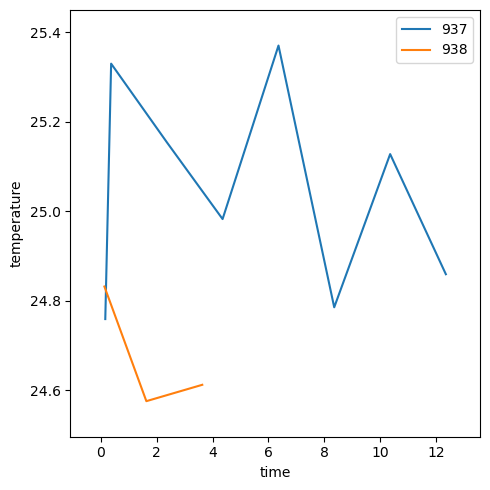

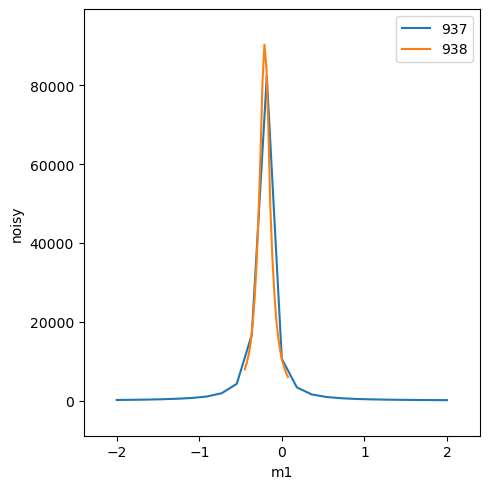

In [3]:
RE(two_pass_scan(md={"motive": "two_pass_scan"}))

## Multi-pass scan

Scan up to 4 times across the peak (in the same direction) starting 
with range of -2 .. +2, then reducing the range of the next scan 
based on the measured FWHM and centering on the measured center position (centroid).

After all scans are complete, report the computed peak centroid and FWHM for each scan in a table.  The motor will be positioned at the last centroid after the last scan.

The `findpeak_multipass` is also from our insturment package.  It calls `bp.rel_scan()` inside a loop for the desired number of iterations.



Transient Scan ID: 939     Time: 2023-04-13 17:01:55
Persistent Unique Scan ID: '841f1016-f954-4f9d-9f1f-984417c01d69'
New stream: 'label_start_motor'
New stream: 'temperature_monitor'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |         m1 |      noisy |
+-----------+------------+------------+------------+
|         1 | 17:01:57.7 |    -2.1000 |  141.70330 |
|         2 | 17:01:58.2 |    -1.9091 |  180.10604 |
|         3 | 17:01:58.7 |    -1.7182 |  220.01310 |
|         4 | 17:01:59.2 |    -1.5273 |  297.27020 |
|         5 | 17:01:59.7 |    -1.3364 |  399.82872 |
|         6 | 17:02:00.2 |    -1.1455 |  580.57415 |
|         7 | 17:02:00.7 |    -0.9546 |  925.49621 |
|         8 | 17:02:01.2 |    -0.7636 | 1594.46591 |
|         9 | 17:02:01.7 |    -0.5727 | 3625.38025 |
|        10 | 17:02:02.2 |    -0.3818 | 14003.98883 |
|        11 | 17:02:02.7 |    -0.1909 | 87128.55953 |
|        12 | 17:02:03.2 |     0.0000 | 10781.7

I Thu-17:02:30 - iterative results:
======= ==================== ===================
scan_id center               FWHM               
======= ==================== ===================
939     -0.19330745175234704 0.2224228216416789 
940     -0.20861123128447245 0.14171756691442283
941     -0.20747604249899584 0.12525759324435487
942     -0.20662333630889465 0.12382359689785855
======= ==================== ===================



m1 now at -0.2066


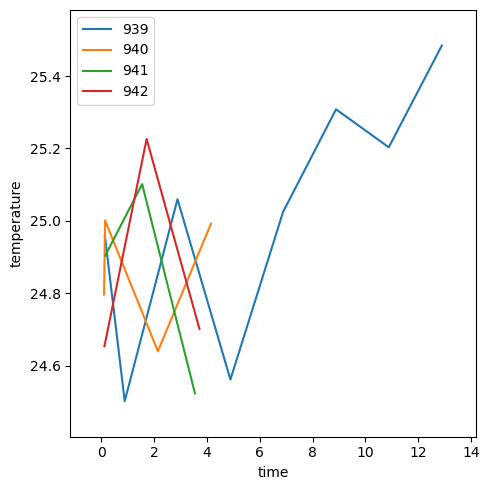

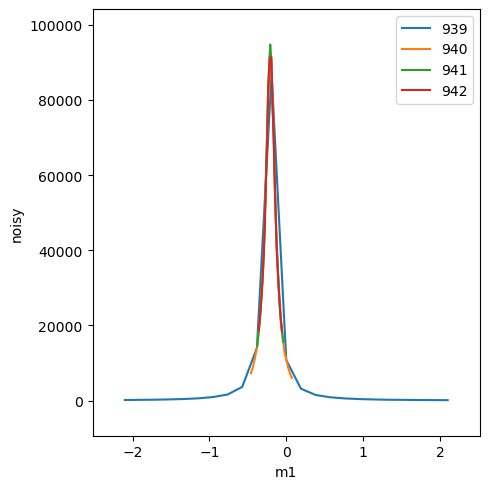

In [4]:
RE(findpeak_multipass(md={"motive": "findpeak_multipass"}))
print(f"{m1.name} now at {m1.position:.4f}")

Show how to re-plot the data from the catalog `cat`.  We'll show the plots of the last three runs.  The measured data is always in the `primary` stream.

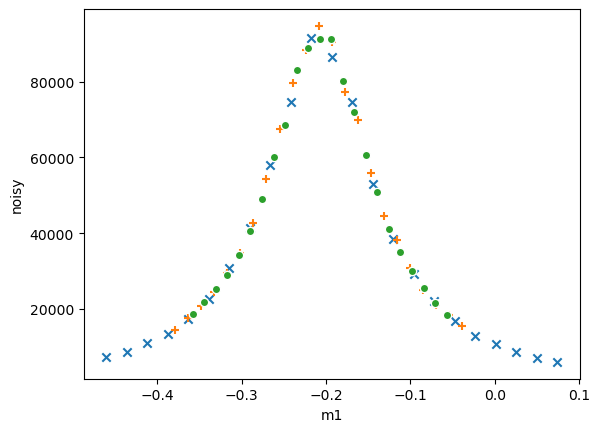

In [5]:
cat[-3].primary.read().plot.scatter(x="m1", y="noisy", marker="x")
cat[-2].primary.read().plot.scatter(x="m1", y="noisy", marker="+")
cat[-1].primary.read().plot.scatter(x="m1", y="noisy", marker="o")

Plot the monitored temperature *v* time.  (See the table of data printed during the scan, the `temperature_monitor` stream was listed near the top of the table.)

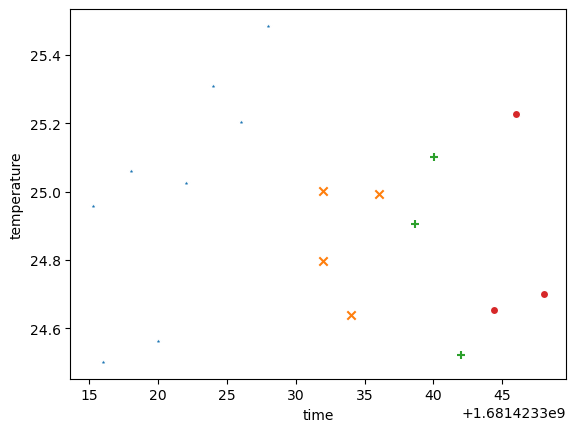

In [6]:
# temperature_monitor
cat[-4].temperature_monitor.read().plot.scatter(x="time", y="temperature", marker="*")
cat[-3].temperature_monitor.read().plot.scatter(x="time", y="temperature", marker="x")
cat[-2].temperature_monitor.read().plot.scatter(x="time", y="temperature", marker="+")
cat[-1].temperature_monitor.read().plot.scatter(x="time", y="temperature", marker="o")